In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import os

# === Leer caracteres únicos desde archivo ===
ruta_vocab = "../data/quijote_letras.txt"
with open(ruta_vocab, "r", encoding="utf-8") as f:
    caracteres = [line[0] for line in f if line.strip() != '']

# Crear diccionarios
char2idx = {u: i for i, u in enumerate(caracteres)}
idx2char = {i: u for i, u in enumerate(caracteres)}

# === Leer texto limpio desde archivo ===
ruta_limpio = "../data/texto_limpio.txt"
with open(ruta_limpio, "r", encoding="utf-8") as f:
    texto_limpio = f.read()

# Filtrar cualquier caracter que no esté en el vocabulario
texto_limpio = ''.join([c for c in texto_limpio if c in char2idx])

# Codificar el texto limpio
texto_codificado = [char2idx[c] for c in texto_limpio]

# === División secuencial entre entrenamiento y validación ===
split_idx = int(len(texto_codificado) * 0.85)
texto_train = texto_codificado[:split_idx]
texto_valid = texto_codificado[split_idx:]

# === Definición del modelo LSTM ===
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# === Función para batches aleatorios ===
def get_batch(data, seq_length, batch_size):
    ix = torch.randint(0, len(data) - seq_length - 1, (batch_size,))
    x_batch = torch.stack([torch.tensor(data[i:i+seq_length]) for i in ix])
    y_batch = torch.stack([torch.tensor(data[i+1:i+seq_length+1]) for i in ix])
    return x_batch.to(device), y_batch.to(device)

# === Hiperparámetros ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(caracteres)
embedding_dim = 96
hidden_dim = 128
num_layers = 1
seq_length = 40
batch_size = 128
epochs = 150
steps_per_epoch = 80
val_steps = 10

modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.AdamW(modelo_lstm.parameters(), lr=0.001, weight_decay=1e-3)

mejor_accuracy = 0.0
patience = 50
patience_counter = 0
ruta_checkpoint = "../modelos/mejor_modelo_lstm2.pth"
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# === Entrenamiento con validación ===
for epoch in range(1, epochs + 1):
    modelo_lstm.train()
    train_loss_total = 0
    train_acc_total = 0

    for _ in range(steps_per_epoch):
        x_batch, y_batch = get_batch(texto_train, seq_length, batch_size)
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

        optimizer_lstm.zero_grad()
        output, _ = modelo_lstm(x_batch, (h0.detach(), c0.detach()))
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion_lstm(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelo_lstm.parameters(), max_norm=1.5)
        optimizer_lstm.step()

        _, pred = torch.max(output, dim=1)
        acc = (pred == y_batch).float().mean().item()
        train_loss_total += loss.item()
        train_acc_total += acc

    avg_train_loss = train_loss_total / steps_per_epoch
    avg_train_accuracy = train_acc_total / steps_per_epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    modelo_lstm.eval()
    val_loss_total = 0
    val_acc_total = 0

    with torch.no_grad():
        for _ in range(val_steps):
            x_val, y_val = get_batch(texto_valid, seq_length, batch_size)
            h0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
            c0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

            output_val, _ = modelo_lstm(x_val, (h0_val, c0_val))
            output_val = output_val.view(-1, vocab_size)
            y_val = y_val.view(-1)

            val_loss = criterion_lstm(output_val, y_val)
            _, pred_val = torch.max(output_val, dim=1)
            val_acc = (pred_val == y_val).float().mean().item()

            val_loss_total += val_loss.item()
            val_acc_total += val_acc

    avg_val_loss = val_loss_total / val_steps
    avg_val_accuracy = val_acc_total / val_steps
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"[LSTM] Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")
    
    if avg_val_accuracy > mejor_accuracy:
        mejor_accuracy = avg_val_accuracy
        patience_counter = 0
        torch.save(modelo_lstm.state_dict(), ruta_checkpoint)
        print(f"Nuevo mejor modelo guardado en: {ruta_checkpoint}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch}")
            break

print(f"Mejor precisión de validación alcanzada: {mejor_accuracy:.4f}")



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[LSTM] Epoch 1/150, Train Loss: 1.0927, Train Acc: 0.6802, Val Loss: 0.0263, Val Acc: 0.9967
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm2.pth
[LSTM] Epoch 2/150, Train Loss: 0.8413, Train Acc: 0.7081, Val Loss: 0.0132, Val Acc: 0.9973
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm2.pth
[LSTM] Epoch 3/150, Train Loss: 0.8363, Train Acc: 0.7095, Val Loss: 0.0139, Val Acc: 0.9966
[LSTM] Epoch 4/150, Train Loss: 0.8326, Train Acc: 0.7112, Val Loss: 0.0127, Val Acc: 0.9964
[LSTM] Epoch 5/150, Train Loss: 0.8333, Train Acc: 0.7111, Val Loss: 0.0092, Val Acc: 0.9972
[LSTM] Epoch 6/150, Train Loss: 0.8320, Train Acc: 0.7115, Val Loss: 0.0107, Val Acc: 0.9968
[LSTM] Epoch 7/150, Train Loss: 0.8322, Train Acc: 0.7112, Val Loss: 0.0094, Val Acc: 0.9974
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm2.pth
[LSTM] Epoch 8/150, Train Loss: 0.8339, Train Acc: 0.7102, Val Loss: 0.0107, Val Acc: 0.9968
[LSTM] Epoch 9/150, Train Loss: 0.8305, Train Acc: 0.7118,

KeyboardInterrupt: 

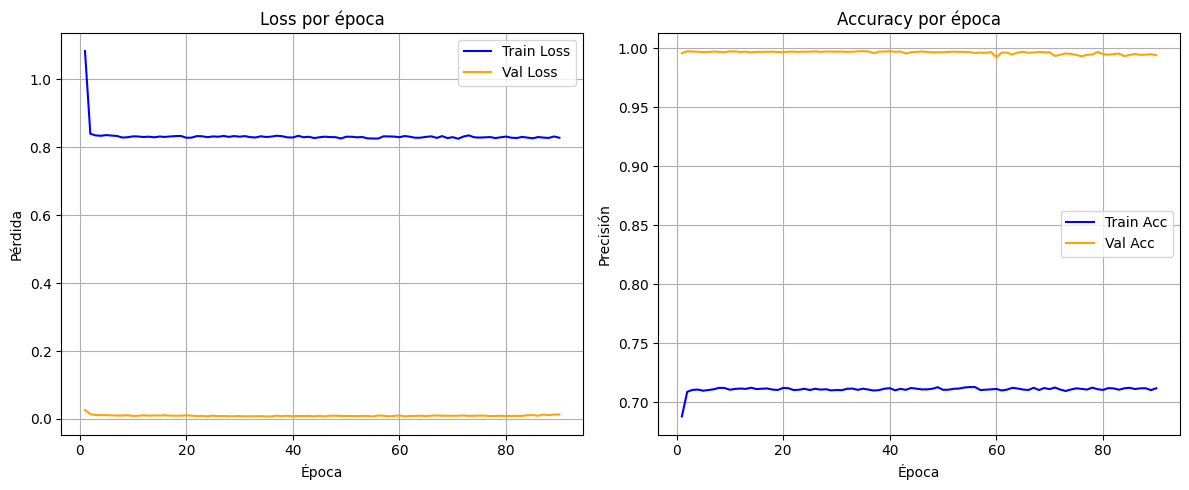

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# === Gráfico de pérdida ===
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color='orange')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Loss por época")
plt.legend()
plt.grid(True)

# === Gráfico de precisión ===
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc", color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Acc", color='orange')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Accuracy por época")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


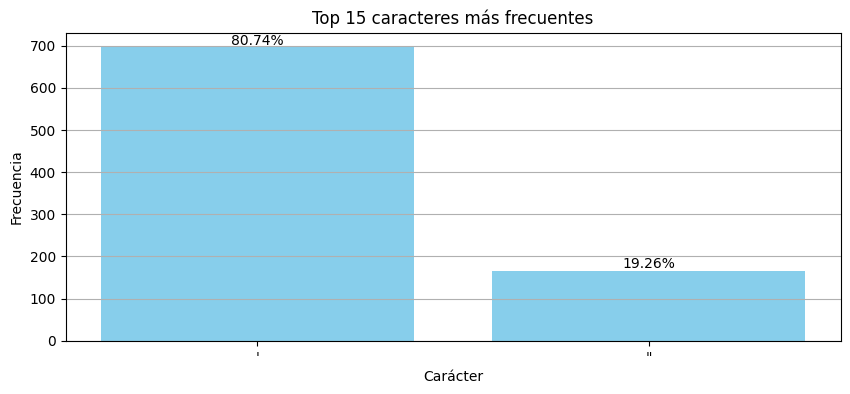

Carácter más común: ''' (80.74%)
Precisión base esperada si el modelo siempre predice ''': 0.8074


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# === Contar frecuencia de cada carácter en el texto limpio ===
conteo = Counter(texto_limpio)
total_caracteres = sum(conteo.values())

# === Mostrar los 15 caracteres más comunes ===
mas_comunes = conteo.most_common(15)
etiquetas, cantidades = zip(*mas_comunes)
porcentajes = [f"{(c / total_caracteres) * 100:.2f}%" for c in cantidades]

# === Gráfico de barras ===
plt.figure(figsize=(10, 4))
plt.bar(etiquetas, cantidades, color='skyblue')
plt.title("Top 15 caracteres más frecuentes")
plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
for i, txt in enumerate(porcentajes):
    plt.text(i, cantidades[i] + max(cantidades)*0.01, txt, ha='center')
plt.grid(axis='y')
plt.show()

# === Mostrar precisión base esperada si el modelo predice siempre el más común ===
caracter_mas_comun, freq_mas_comun = mas_comunes[0]
prob_base = freq_mas_comun / total_caracteres
print(f"Carácter más común: '{caracter_mas_comun}' ({prob_base*100:.2f}%)")
print(f"Precisión base esperada si el modelo siempre predice '{caracter_mas_comun}': {prob_base:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[LSTM] Epoch 1/150, Train Loss: 1.3194, Train Acc: 0.6367, Val Loss: 0.0432, Val Acc: 0.9922
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm3.pth
[LSTM] Epoch 2/150, Train Loss: 0.8585, Train Acc: 0.7087, Val Loss: 0.0220, Val Acc: 0.9918
[LSTM] Epoch 3/150, Train Loss: 0.8479, Train Acc: 0.7081, Val Loss: 0.0188, Val Acc: 0.9920
[LSTM] Epoch 4/150, Train Loss: 0.8427, Train Acc: 0.7096, Val Loss: 0.0188, Val Acc: 0.9916
[LSTM] Epoch 5/150, Train Loss: 0.8437, Train Acc: 0.7087, Val Loss: 0.0178, Val Acc: 0.9923
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm3.pth
[LSTM] Epoch 6/150, Train Loss: 0.8480, Train Acc: 0.7098, Val Loss: 0.0187, Val Acc: 0.9925
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm3.pth
[LSTM] Epoch 7/150, Train Loss: 0.8450, Train Acc: 0.7090, Val Loss: 0.0185, Val Acc: 0.9892
[LSTM] Epoch 8/150, Train Loss: 0.8465, Train Acc: 0.7082, Val Loss: 0.0179, Val Acc: 0.9925
[LSTM] Epoch 9/150, Train Loss: 0.8440, Train Acc: 0.7091,

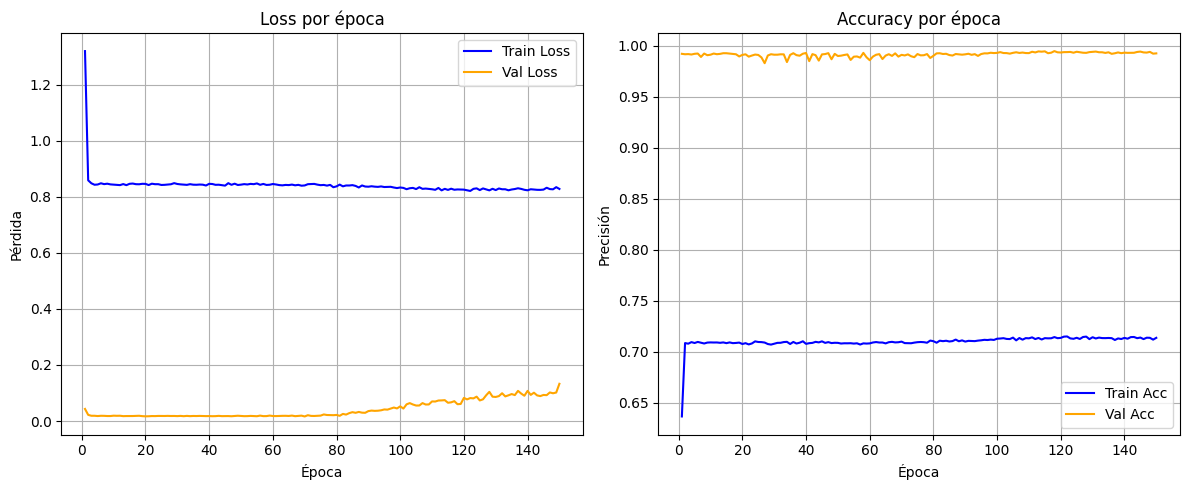

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import os

# === Configuración de dispositivo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Leer caracteres únicos desde archivo ===
ruta_vocab = "../data/quijote_letras.txt"
with open(ruta_vocab, "r", encoding="utf-8") as f:
    caracteres = [line[0] for line in f if line.strip() != '']

# Crear diccionarios
char2idx = {u: i for i, u in enumerate(caracteres)}
idx2char = {i: u for i, u in enumerate(caracteres)}

# === Leer texto limpio desde archivo ===
ruta_limpio = "../data/texto_limpio.txt"
with open(ruta_limpio, "r", encoding="utf-8") as f:
    texto_limpio = f.read()

# Filtrar cualquier caracter que no esté en el vocabulario
texto_limpio = ''.join([c for c in texto_limpio if c in char2idx])

# Codificar el texto limpio
texto_codificado = [char2idx[c] for c in texto_limpio]

# División entre entrenamiento y validación
texto_train, texto_valid = train_test_split(texto_codificado, test_size=0.15, random_state=42)

# === Definición del modelo LSTM ===
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# === Función para batches aleatorios ===
def get_batch(data, seq_length, batch_size):
    ix = torch.randint(0, len(data) - seq_length - 1, (batch_size,))
    x_batch = torch.stack([torch.tensor(data[i:i+seq_length]) for i in ix])
    y_batch = torch.stack([torch.tensor(data[i+1:i+seq_length+1]) for i in ix])
    return x_batch.to(device), y_batch.to(device)

# === Hiperparámetros ===
vocab_size = len(caracteres)
embedding_dim = 96
hidden_dim = 128
num_layers = 1
seq_length = 40
batch_size = 128
epochs = 150
steps_per_epoch = 80
val_steps = 10

# === Inicializar modelo y optimizador ===
modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
optimizer_lstm = torch.optim.AdamW(modelo_lstm.parameters(), lr=0.001, weight_decay=1e-3)

# === Calcular pesos para la pérdida ponderada ===
conteo = Counter(texto_train)
total = sum(conteo.values())
pesos = torch.ones(vocab_size)
for idx in range(vocab_size):
    frecuencia = conteo.get(idx, 0) / total
    pesos[idx] = 1.0 / frecuencia if frecuencia > 0 else 0.0
pesos = pesos / pesos.sum() * vocab_size
pesos = pesos.to(device)

criterion_lstm = nn.CrossEntropyLoss(weight=pesos)

# === Entrenamiento con validación ===
mejor_accuracy = 0.0
patience = 50
patience_counter = 0
ruta_checkpoint = "../modelos/mejor_modelo_lstm3.pth"
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, epochs + 1):
    modelo_lstm.train()
    train_loss_total = 0
    train_acc_total = 0

    for _ in range(steps_per_epoch):
        x_batch, y_batch = get_batch(texto_train, seq_length, batch_size)
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

        optimizer_lstm.zero_grad()
        output, _ = modelo_lstm(x_batch, (h0.detach(), c0.detach()))
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion_lstm(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelo_lstm.parameters(), max_norm=1.5)
        optimizer_lstm.step()

        _, pred = torch.max(output, dim=1)
        acc = (pred == y_batch).float().mean().item()
        train_loss_total += loss.item()
        train_acc_total += acc

    avg_train_loss = train_loss_total / steps_per_epoch
    avg_train_accuracy = train_acc_total / steps_per_epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    modelo_lstm.eval()
    val_loss_total = 0
    val_acc_total = 0

    with torch.no_grad():
        for _ in range(val_steps):
            x_val, y_val = get_batch(texto_valid, seq_length, batch_size)
            h0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
            c0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

            output_val, _ = modelo_lstm(x_val, (h0_val, c0_val))
            output_val = output_val.view(-1, vocab_size)
            y_val = y_val.view(-1)

            val_loss = criterion_lstm(output_val, y_val)
            _, pred_val = torch.max(output_val, dim=1)
            val_acc = (pred_val == y_val).float().mean().item()

            val_loss_total += val_loss.item()
            val_acc_total += val_acc

    avg_val_loss = val_loss_total / val_steps
    avg_val_accuracy = val_acc_total / val_steps
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"[LSTM] Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")
    
    if avg_val_accuracy > mejor_accuracy:
        mejor_accuracy = avg_val_accuracy
        patience_counter = 0
        torch.save(modelo_lstm.state_dict(), ruta_checkpoint)
        print(f"Nuevo mejor modelo guardado en: {ruta_checkpoint}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch}")
            break

print(f"Mejor precisión de validación alcanzada: {mejor_accuracy:.4f}")

# === GRAFICAR RESULTADOS ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="orange")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Loss por época")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc", color="blue")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Acc", color="orange")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Accuracy por época")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
